In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


In [2]:
train_dir = '/kaggle/input/tomatodiseaseclassificationgp/Tomato Leaf Disease/Train'
val_dir = '/kaggle/input/tomatodiseaseclassificationgp/Tomato Leaf Disease/Val'
test_dir = '/kaggle/input/tomatodiseaseclassificationgp/Tomato Leaf Disease/Test'

img_size = (224, 224)
batch_size = 32

In [3]:
train_dataset = image_dataset_from_directory(train_dir, image_size=img_size, batch_size=batch_size)
val_dataset = image_dataset_from_directory(val_dir, image_size=img_size, batch_size=batch_size)
test_dataset = image_dataset_from_directory(test_dir, image_size=img_size, batch_size=batch_size)

Found 33851 files belonging to 9 classes.
Found 2647 files belonging to 9 classes.
Found 566 files belonging to 9 classes.


In [6]:
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  

x = base_model.output
x = GlobalAveragePooling2D()(x)  
x = Dropout(0.5)(x)  
x = Dense(128, activation='relu')(x)  
output_layer = Dense(9, activation='softmax')(x)  


model = Model(inputs=base_model.input, outputs=output_layer)


model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.summary()  

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,214,700 (16.08 MB)

 Trainable params: 165,129 (645.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [7]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)

Epoch 1/10
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 86s 60ms/step - accuracy: 0.6566 - loss: 1.0126 - val_accuracy: 0.8682 - val_loss: 0.4056
Epoch 2/10
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 44s 42ms/step - accuracy: 0.7971 - loss: 0.5916 - val_accuracy: 0.8976 - val_loss: 0.3252
Epoch 3/10
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.8197 - loss: 0.5204 - val_accuracy: 0.9067 - val_loss: 0.2949
Epoch 4/10
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 43s 41ms/step - accuracy: 0.8390 - loss: 0.4694 - val_accuracy: 0.9048 - val_loss: 0.2942
Epoch 5/10
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 42s 39ms/step - accuracy: 0.8490 - loss: 0.4414 - val_accuracy: 0.9150 - val_loss: 0.2669
Epoch 6/10
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 42s 40ms/step - accuracy: 0.8539 - loss: 0.4189 - val_accuracy: 0.9135 - val_loss: 0.2779
Epoch 7/10
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 42s 40ms/step - accuracy: 0.8663 - loss: 0.3869 - val_accuracy: 0.9173 - val_loss: 0.2607
Epoch 8/10
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 42s 40ms/step - accuracy: 0.8706 -

In [9]:
val_loss, val_acc = model.evaluate(val_dataset)
print(f"Test Accuracy: {val_acc * 100:.2f}%")

83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9239 - loss: 0.2489
Test Accuracy: 91.88%


In [8]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 399ms/step - accuracy: 0.9692 - loss: 0.1513
Test Accuracy: 96.64%


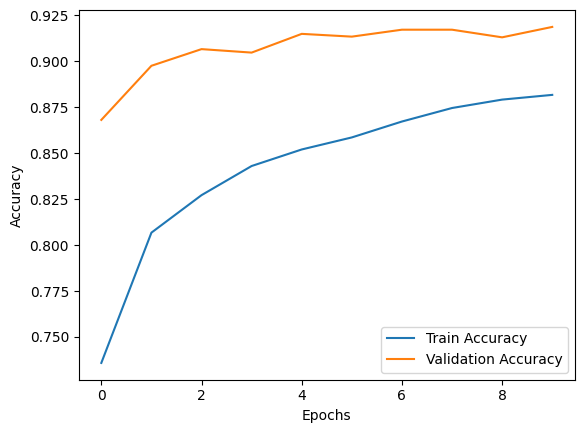

In [10]:
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


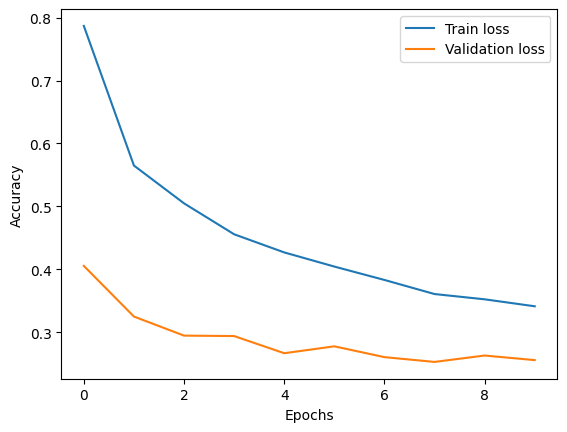

In [11]:
plt.plot(history.history["loss"], label="Train loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [12]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [13]:
y_true = np.concatenate([y for x, y in test_dataset], axis=0) 
y_pred = np.argmax(model.predict(test_dataset), axis=1)  


18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 376ms/step


In [14]:
cm = confusion_matrix(y_true, y_pred)

class_names = ['Early Blight', 'Healthy', 'Late Blight', 'Leaf Miner', 
               'Leaf Mold', 'Mosaic Virus', 'Septoria', 'Spider Mites', 'Yellow Leaf Curl Virus']


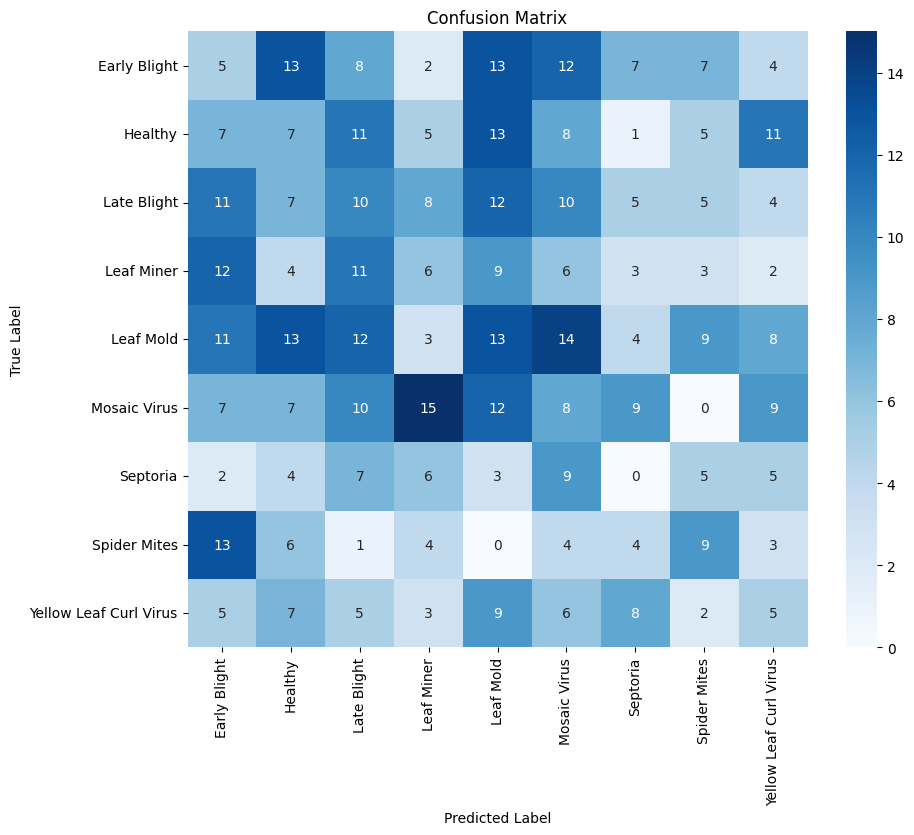

In [15]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [16]:
print(classification_report(y_true, y_pred, target_names=class_names))


                        precision    recall  f1-score   support

          Early Blight       0.07      0.07      0.07        71
               Healthy       0.10      0.10      0.10        68
           Late Blight       0.13      0.14      0.14        72
            Leaf Miner       0.12      0.11      0.11        56
             Leaf Mold       0.15      0.15      0.15        87
          Mosaic Virus       0.10      0.10      0.10        77
              Septoria       0.00      0.00      0.00        41
          Spider Mites       0.20      0.20      0.20        44
Yellow Leaf Curl Virus       0.10      0.10      0.10        50

              accuracy                           0.11       566
             macro avg       0.11      0.11      0.11       566
          weighted avg       0.11      0.11      0.11       566



In [17]:
model.save("EfficientNet_model.h5")

In [18]:
model = tf.keras.models.load_model("/kaggle/working/EfficientNet_model.h5") 

In [20]:
from tensorflow.keras.preprocessing import image
image_path = "/kaggle/input/tomatodiseaseclassificationgp/Tomato Leaf Disease/Test/Late Blight/1.jpg"  # Replace with the actual image path

img = image.load_img(image_path, target_size=(224, 224))  
img_array = image.img_to_array(img)  
img_array = np.expand_dims(img_array, axis=0)  
img_array = img_array / 255.0  


In [21]:
class_names = ['Early Blight', 'Healthy', 'Late Blight', 'Leaf Miner', 
               'Leaf Mold', 'Mosaic Virus', 'Septoria', 'Spider Mites', 'Yellow Leaf Curl Virus']


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


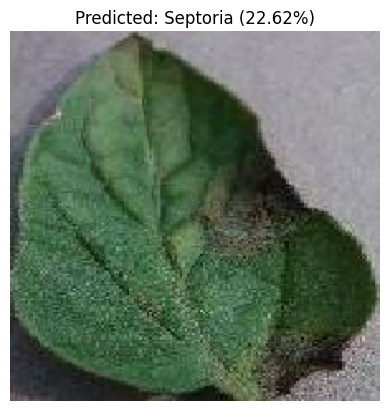

In [22]:
predictions = model.predict(img_array)  
predicted_class = np.argmax(predictions)  
predicted_label = class_names[predicted_class]  

plt.imshow(img)
plt.axis("off")
plt.title(f"Predicted: {predicted_label} ({predictions[0][predicted_class] * 100:.2f}%)")
plt.show()
